# Passive Cable Models

The Passive Cable Model describes how electrical signals propagate along neuronal processes with spatial extent, such as dendrites and axons. Unlike point neuron models (like LIF or QIF) which treat the entire neuron as a single compartment with uniform potential, cable models explicitly represent the spatial dimension of neurons. This allows them to capture important phenomena such as signal attenuation, delay, and filtering that occur as electrical signals travel along neuronal processes.

## Key Properties

1. **Spatial Representation**: Models neurons as cylindrical cables with defined length and diameter
2. **Electrotonic Properties**: Characterizes signal propagation in terms of length constants and electrotonic distance
3. **Signal Attenuation**: Captures how potentials decrease in amplitude as they travel along dendrites
4. **Temporal Filtering**: Demonstrates how high-frequency signals are filtered out at greater distances
5. **Boundary Conditions**: Allows specification of different termination conditions (sealed, open, semi-infinite)

## Mathematical Description

The passive cable is described by the cable equation:

λ²(∂²V/∂x²) = τm(∂V/∂t) + V - Vrest

Where:
- λ = sqrt(rm/ri) is the length constant
- τm = rm·cm is the membrane time constant

For steady-state conditions (∂V/∂t = 0):
λ²(∂²V/∂x²) = V - Vrest

Parameters:
- V(x,t): Membrane potential at position x and time t
- Vrest: Resting membrane potential (typically -70 mV)
- rm: Specific membrane resistance (typically 10,000-40,000 Ω·cm²)
- ri: Intracellular resistivity (typically 70-300 Ω·cm)
- cm: Specific membrane capacitance (typically 0.9-1.0 μF/cm²)
- d: Cable diameter (typically 0.5-2 μm for dendrites)
- L: Cable length (typically 50-500 μm for dendrites)
- Ri = ri/(π·(d/2)²): Axial resistance per unit length
- Rm = rm/(2π·(d/2)): Membrane resistance times unit length
- Cm = cm·2π·(d/2): Membrane capacitance per unit length
- λ = sqrt(rm·d/(4·ri)): Length constant (typically 0.1-1 mm)
- τm = rm·cm: Membrane time constant (typically 10-50 ms)

State Variables:
- V(x,t): Membrane potential at each position x and time t (initialize at Vrest)

Time and Space-related variables:
- dt: Time step for numerical integration
- dx: Spatial discretization step
- t: Current simulation time
- tmax: Maximum simulation time
- X: Position along the cable (0 ≤ X ≤ L)

## Algorithm

1. Initialize state variables
   - V(x,0) = Vrest for all positions x
   - Set boundary and initial conditions

2. Spatial discretization
   - Divide cable into N segments of length dx
   - Create position vector X = [0, dx, 2dx, ..., L]
   - Define dimensionless electrotonic distance X/λ

3. For each time step from t=0 to t=tmax:
   
   a. Apply boundary conditions
      - At x=0: Specified voltage, current injection, or sealed end
      - At x=L: Typically sealed end (∂V/∂x = 0) or open end (V = Vrest)
   
   b. For each interior position x:
      - Compute second spatial derivative using central difference:
        ∂²V/∂x² ≈ (V(x+dx,t) - 2V(x,t) + V(x-dx,t))/dx²
      
      - Compute temporal derivative:
        ∂V/∂t = (λ²∂²V/∂x² - (V - Vrest))/τm
   
   c. Update potential using explicit Euler method (or Crank-Nicolson for stability):
      - V(x,t+dt) = V(x,t) + dt·∂V/∂t
   
   d. Store variables for plotting
      - Record V(x,t) at selected positions and times
   
   e. Increment time: t = t + dt

4. Analyze and visualize results
   - Plot voltage vs position at different times
   - Plot voltage vs time at different positions
   - Calculate signal attenuation and delay
   - Generate space-time color maps of membrane potential

## Characteristic Behaviors

1. **Steady-State Decay**: For constant input at one end, voltage decays exponentially with distance (e^(-x/λ))
2. **Temporal Filtering**: High-frequency inputs are increasingly attenuated at greater distances
3. **Signal Delay**: Action potentials and synaptic potentials are delayed as they propagate along the cable
4. **Summation Properties**: Nonlinear spatial summation of inputs at different locations along the dendrite
5. **End Effects**: Sealed ends cause reflection and enhancement of signals near boundaries

## Biological Mechanisms Represented

The passive cable model represents:
- Electrical properties of the neuronal membrane (resistance, capacitance)
- Cytoplasmic resistivity that impedes current flow
- Leakage currents through ion channels
- Passive propagation of signals along dendrites
- Electrotonic properties that determine signal integration
- Spatial filtering properties of dendritic trees

## Applications

The passive cable model is particularly useful for:
- Understanding dendritic integration of synaptic inputs
- Analyzing how dendrite morphology affects signal processing
- Estimating the effect of dendrite diameter and length on signal propagation
- Interpreting intracellular recording data
- Designing experiments to investigate dendritic properties
- Building foundation for more complex multi-compartment models with active properties
- Teaching core principles of neuronal electrophysiology

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class PassiveCable():
    def __init__(self, length, segments, Cm, R, V_rest, time_steps, 
                 input_location=None, input_amplitude=None, input_duration=None):
        self.length = length  # Length of cable (µm)
        self.segments = segments  # Number of segments to discretize the cable
        self.Cm = Cm  # Membrane capacitance (nF)
        self.R = R    # Membrane resistance (MΩ)
        self.V_rest = V_rest  # Resting voltage (mV)
        self.time_steps = time_steps
        
        # Derived parameters
        self.tau = R * Cm  # Time constant (ms)
        self.dx = length / segments  # Spatial step size (µm)
        
        # Cable-specific parameters
        self.R_i = 100  # Intracellular resistivity (Ω·cm)
        self.diam = 1.0  # Cable diameter (µm)
        
        # Derived cable parameters
        self.r_i = (self.R_i * 4) / (np.pi * self.diam**2)  # Intracellular resistance per unit length (MΩ/µm)
        self.lambda_sq = (self.diam) / (4 * self.r_i * (1/self.R))  # Length constant squared (µm²)
        
        # Input current parameters
        self.input_location = input_location if input_location is not None else int(segments/2)  # Default to middle
        self.input_amplitude = input_amplitude if input_amplitude is not None else 1.0  # nA
        self.input_duration = input_duration if input_duration is not None else 5.0  # ms
    
    def simulate(self):
        # Initialize voltage array: dimensions are [time, space]
        V = np.ones((len(self.time_steps), self.segments)) * self.V_rest
        
        dt = self.time_steps[1] - self.time_steps[0]  # Time step
        
        # Simulation using finite difference method
        for t_idx in range(len(self.time_steps) - 1):
            t = self.time_steps[t_idx]
            
            # Current injection (simplified as a square pulse at a specific location)
            I = np.zeros(self.segments)
            if t < self.input_duration:
                I[self.input_location] = self.input_amplitude
            
            # Update each segment
            for i in range(1, self.segments - 1):  # Skip boundary segments for now
                # Second spatial derivative using central difference
                d2V_dx2 = (V[t_idx, i+1] - 2*V[t_idx, i] + V[t_idx, i-1]) / (self.dx**2)
                
                # Cable equation: dV/dt = lambda^2 * d2V/dx2 - (V-Vrest)/tau + R*I
                dV_dt = (self.lambda_sq * d2V_dx2 - 
                         (V[t_idx, i] - self.V_rest) / self.tau + 
                         self.R * I[i])
                
                # Euler method time integration
                V[t_idx + 1, i] = V[t_idx, i] + dt * dV_dt
            
            # Handle boundaries with sealed end (no-flux) condition: dV/dx = 0
            # This is implemented by setting the boundary value equal to its adjacent value
            V[t_idx + 1, 0] = V[t_idx + 1, 1]
            V[t_idx + 1, -1] = V[t_idx + 1, -2]
        
        return V
    
    def plot_results(self, V):
        import matplotlib.pyplot as plt
        from matplotlib.animation import FuncAnimation
        
        # 1. Plot voltage vs position at different time points
        plt.figure(figsize=(12, 6))
        x = np.linspace(0, self.length, self.segments)
        
        # Plot at different time points
        time_points = [0, 5, 10, 20, 50]
        time_indices = [np.abs(self.time_steps - t).argmin() for t in time_points if t < self.time_steps[-1]]
        
        for idx in time_indices:
            plt.plot(x, V[idx, :], label=f't = {self.time_steps[idx]:.1f} ms')
        
        plt.xlabel('Position (µm)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Voltage Propagation in Passive Cable')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 2. Plot voltage vs time at different positions
        plt.figure(figsize=(12, 6))
        
        # Plot at different positions
        pos_indices = [0, int(self.segments/4), int(self.segments/2), int(3*self.segments/4), self.segments-1]
        for idx in pos_indices:
            plt.plot(self.time_steps, V[:, idx], 
                    label=f'x = {x[idx]:.1f} µm')
        
        plt.axhline(y=self.V_rest, color='k', linestyle='--', alpha=0.7, label='Rest')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Voltage at Different Positions Along Cable')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 3. Create a heatmap visualization of voltage over space and time
        plt.figure(figsize=(10, 8))
        plt.imshow(V.T, aspect='auto', origin='lower', 
                  extent=[self.time_steps[0], self.time_steps[-1], 0, self.length],
                  cmap='viridis', interpolation='nearest')
        
        plt.colorbar(label='Membrane Potential (mV)')
        plt.xlabel('Time (ms)')
        plt.ylabel('Position (µm)')
        plt.title('Voltage Propagation in Passive Cable')
        plt.tight_layout()
        plt.show()
        
    def animate_results(self, V):
        """Create an animation of the voltage propagation"""
        import matplotlib.pyplot as plt
        from matplotlib.animation import FuncAnimation
        
        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.linspace(0, self.length, self.segments)
        line, = ax.plot(x, V[0, :])
        
        ax.set_ylim(V.min() - 1, V.max() + 1)
        ax.set_xlabel('Position (µm)')
        ax.set_ylabel('Membrane Potential (mV)')
        ax.set_title('Voltage Propagation in Passive Cable')
        ax.grid(True)
        
        time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
        
        def init():
            line.set_ydata(V[0, :])
            time_text.set_text(f'Time: {self.time_steps[0]:.1f} ms')
            return line, time_text
        
        def update(frame):
            line.set_ydata(V[frame, :])
            time_text.set_text(f'Time: {self.time_steps[frame]:.1f} ms')
            return line, time_text
        
        anim = FuncAnimation(fig, update, frames=range(0, len(self.time_steps), 10),
                            init_func=init, blit=True)
        
        plt.close()  # Prevent duplicate display in notebooks
        return anim

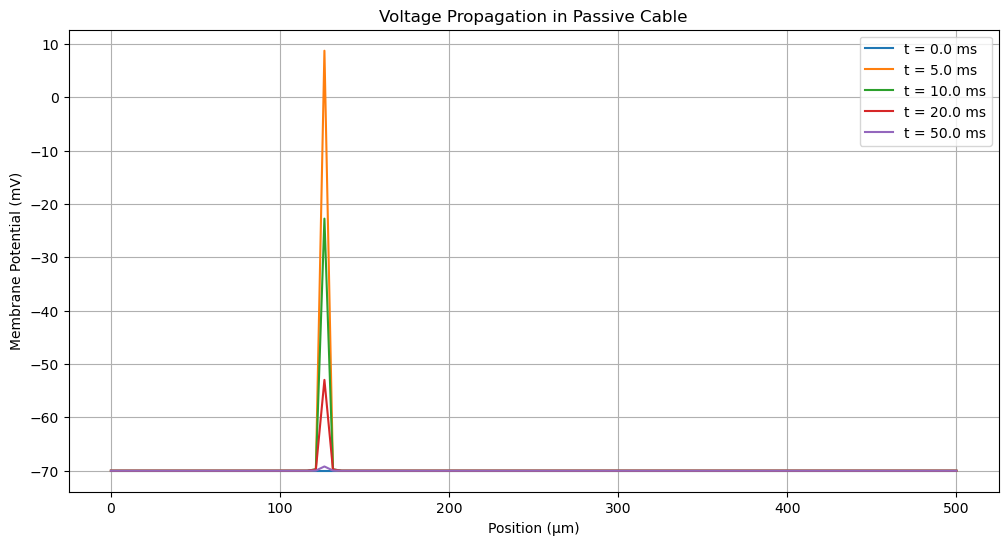

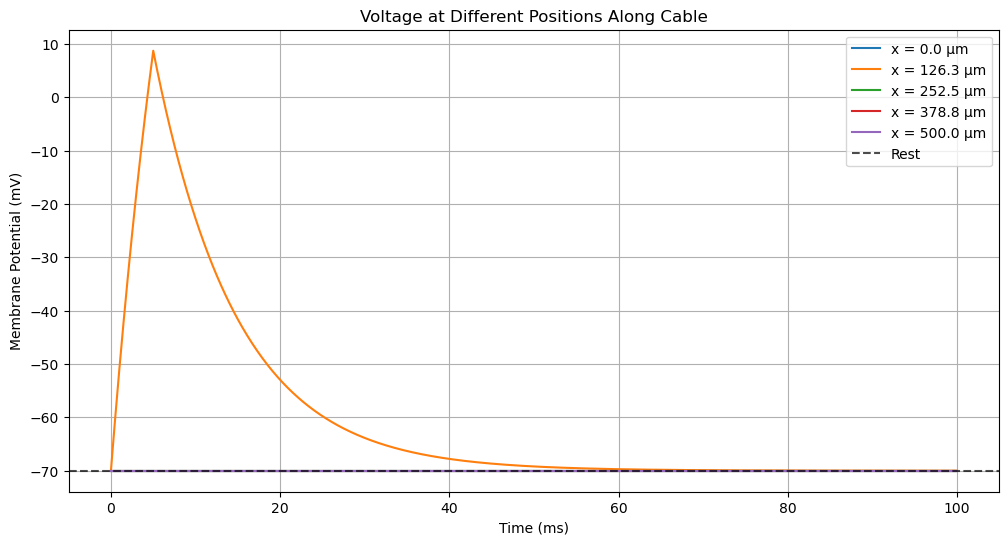

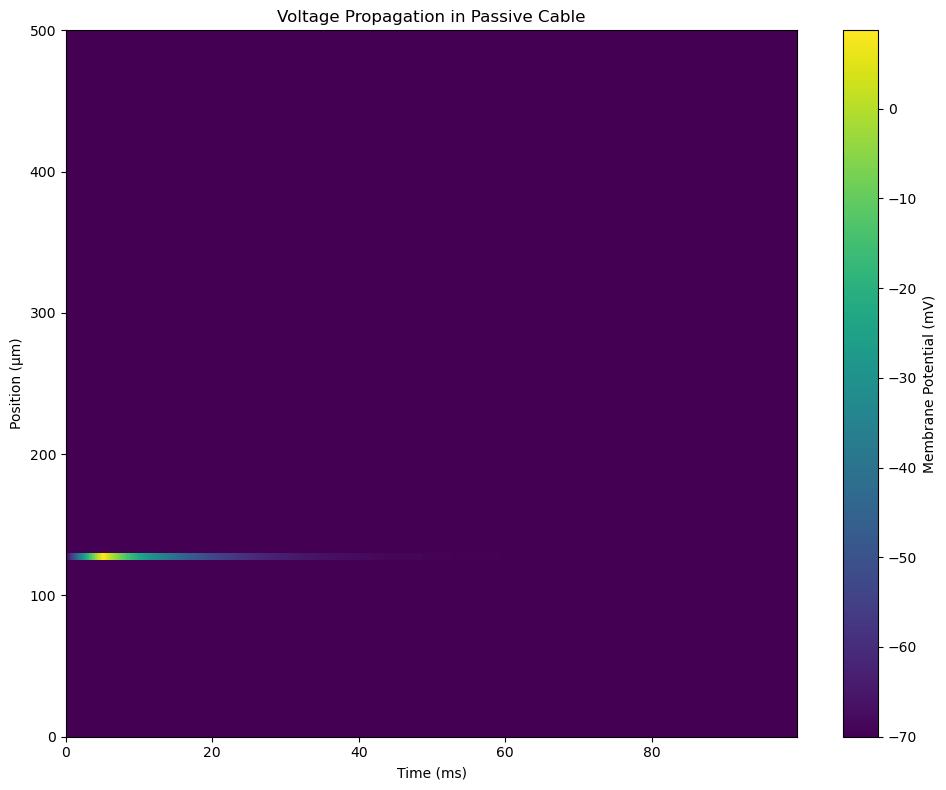

In [3]:
# Example usage of the Passive Cable model
t_max = 100  # ms
dt = 0.1  # ms
time_steps = np.arange(0, t_max, dt)

# Create passive cable model
cable = PassiveCable(
    length=500,        # µm
    segments=100,      # Number of segments
    Cm=1,              # nF
    R=10,              # MΩ
    V_rest=-70,        # mV
    time_steps=time_steps,
    input_location=25, # Segment for current injection
    input_amplitude=2, # nA
    input_duration=5   # ms
)

# Run simulation
voltage = cable.simulate()

# Plot results
cable.plot_results(voltage)

# Create animation (optional)
# anim = cable.animate_results(voltage)
# from IPython.display import HTML
# HTML(anim.to_jshtml())